# Import some packages

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import shutil
import time
from copy import deepcopy

device = 'cuda'
import torchvision.models as models

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Load data

In [3]:
train_df = pd.read_csv("../data/kaggle/train.csv")
test_df = pd.read_csv("../data/kaggle/test.csv")
print(f"Train dataframe has shape: {train_df.shape}")
print(f"Test dataframe has shape: {test_df.shape}")
display(train_df.head())
display(test_df.head())

Train dataframe has shape: (31390, 5)
Test dataframe has shape: (2413, 4)


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


# Transforming 
This will convert each protein sequence (a list of amino acids) to a matrix, where each row is the physical and chemical properties of the corresponding amino acid

In [4]:
df_aa = pd.read_csv("../data/aminoacids.csv")
transform_dict = {}
"""
0 = Name (Ignore)
1 = Abbr (Ignore)
2 = Letter
3 = Molecular Weight
4 = Molecular Formula (Ignore)
5 = Residue Formula (Ignore)
6 = Residue Weight 
7 = pKa1 -> positively correlated to polarity
8 = pKb2 -> positively correlated to polarity
9 = pKx3 -> positively correlated to polarity
10 = pl4
11 = H
12 = VSC
13 = P1
14 = P2
15 = SASA
16 = NCISC
17 = carbon
18 = hydrogen
19 = nitrogen
20 = oxygen
21 = sulfur
"""
feature_list = [3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
df_aa.iloc[:, feature_list] = (df_aa.iloc[:, feature_list] - df_aa.iloc[:, feature_list].mean()) / df_aa.iloc[:, feature_list].std()
df_aa = df_aa.fillna(0)

In [5]:
# feature_list chooses which physical and chemical properties to inlcude
def getTransformDict(feature_list = [3, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
  transform_dict = {}
  for index, row in df_aa.iterrows():
    row_values = row.values
    letter = row_values[2]
    the_rest = [row_values[i] for i in feature_list]
    transform_dict.update({letter: np.array(the_rest, dtype="float")})
  transform_dict.update({None: np.zeros(shape=len(feature_list),dtype="float")})
  return transform_dict

In [6]:
# convert list of amino acids into a matrix of their corresponding physical and chemical properties
def convertSequences(sequences, MAX_LENGTH, transform_dict=None):
  if transform_dict is None:
    transform_dict = getTransformDict()
  sequenceList = []
  for sequence in sequences:
    letterMatrix = []
    for i in range(MAX_LENGTH):
      if i < len(sequence):
        letterMatrix.append(transform_dict[sequence[i]])
      else:
        letterMatrix.append(transform_dict[None])
    sequenceList.append(np.array(letterMatrix))
  return sequenceList

In [7]:
def getSequences(df, MAX_LENGTH=224):
  df.reset_index(inplace=True)
  sequences = [list(string) for string in df["protein_sequence"].values.tolist()]
  return convertSequences(sequences, MAX_LENGTH)

In [8]:
def filterDataFrame(df, MIN_LENGTH=100, MAX_LENGTH=224):
    df["protein_sequence_len"] = df["protein_sequence"].apply(lambda x: len(x))
    df = df[df["protein_sequence_len"] <= MAX_LENGTH]
    df = df[df["protein_sequence_len"] >= MIN_LENGTH]
    if 'tm' in df:
        df['tm'] = (df['tm'] - df['tm'].mean())/df['tm'].std()
    return df

In [9]:
from sklearn.model_selection import train_test_split

MAX_LENGTH = 224
MIN_LENGTH = 100
train_df = filterDataFrame(train_df, MIN_LENGTH=MIN_LENGTH, MAX_LENGTH=MAX_LENGTH)
X = getSequences(train_df, MAX_LENGTH=MAX_LENGTH)
y = train_df['tm'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))

6201


In [10]:
test_df = filterDataFrame(test_df, MIN_LENGTH=MIN_LENGTH, MAX_LENGTH=MAX_LENGTH)
X_test = getSequences(test_df)

## Loading and normalizing

In [11]:
def toTensor(array):
    tensor = torch.Tensor(np.array(array))
    return tensor.view(tensor.size(dim=0), 1, tensor.size(dim=1), tensor.size(dim=2))

In [12]:
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(toTensor(X_train), torch.Tensor(y_train))
valset = TensorDataset(toTensor(X_val), torch.Tensor(y_val))
testset = TensorDataset(toTensor(X_test))

#TODO: revise batch_size
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define the model

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(64 * 108, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x.squeeze()

In [14]:
model = Net().to(device)

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Define the Training Functions

In [17]:
%%time
best_val_loss = 100000
best_val_model = None
MAX_EPOCH = 10
loss_record = {'train': [], 'dev': []} # added
for epoch in range(MAX_EPOCH):  
    model.train()
    running_train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        # outputs = outputs.view(outputs.size(dim=0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_train_loss += loss.sum().item()
        out = outputs.detach()
        assert out.shape == labels.shape
        
    loss_record['train'].append(running_train_loss/len(trainset))
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = out.detach()
            running_val_loss += (torch.pow(out - labels, 2).sum().item()) ** 0.5
    loss_record['dev'].append(running_val_loss/len(valset))
    print("Epoch [{:>2} / {}]: Train loss = {:<25} Val Loss = {:<25}".format(epoch+1, MAX_EPOCH, running_train_loss/len(trainset), running_val_loss/len(valset)))
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')

Epoch [ 1 / 10]: Train loss = 0.015152902602957171      Val Loss = 0.14922022973625082      
Epoch [ 2 / 10]: Train loss = 0.01432430521170375       Val Loss = 0.15031680601643171      
Epoch [ 3 / 10]: Train loss = 0.013832474827593401      Val Loss = 0.14911122135922683      
Epoch [ 4 / 10]: Train loss = 0.01270610557373753       Val Loss = 0.1473412437999071       
Epoch [ 5 / 10]: Train loss = 0.01286203486412653       Val Loss = 0.1494170181233911       
Epoch [ 6 / 10]: Train loss = 0.012389552592510294      Val Loss = 0.14633468106520187      
Epoch [ 7 / 10]: Train loss = 0.012239192289712833      Val Loss = 0.1468232397523724       
Epoch [ 8 / 10]: Train loss = 0.012152222549121353      Val Loss = 0.1451650533159102       
Epoch [ 9 / 10]: Train loss = 0.011975279549180913      Val Loss = 0.14780657672365125      
Epoch [10 / 10]: Train loss = 0.011923050991211605      Val Loss = 0.14402597098297826      
Finished Training
Wall time: 1min 7s


In [18]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [19]:
def plot_learning_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = range(len(record['train']))
    x_2 = range(len(record['dev']))
    figure(figsize=(6, 4))
    plt.plot(x_1, record['train'], c='tab:red', label='train')
    plt.plot(x_2, record['dev'], c='tab:cyan', label='dev')
    
    # TODO: feel free to change this range to see the learning curve better
    y_min = min(min(record['train']), min(record['dev']))
    y_max = max(max(record['train']), max(record['dev']))
    plt.ylim(max(.95*y_min-0.01, 0), 1.05*y_max+0.01)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

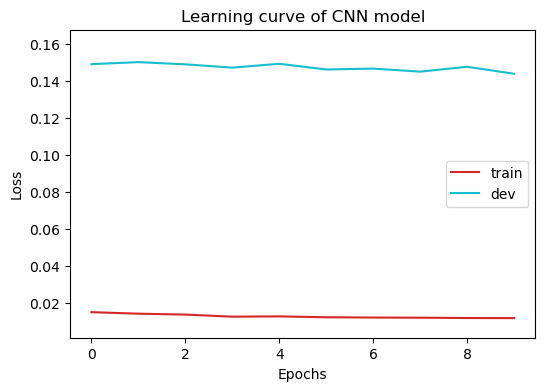

In [20]:
plot_learning_curve(loss_record, title="CNN model")

In [27]:
%%time
preds = []
model.load_state_dict(best_val_model)
model.eval()
with torch.no_grad():
    for inputs in testloader:
        inputs = inputs[0]
        out = model(inputs.cuda()).cpu()
        preds.append(out.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

Wall time: 2.09 s


In [ ]:
def make_prediction(preds, file):
    print(f'Saving results to {file}')
    submission = pd.read_csv("../data/kaggle/sample_submission.csv")
    submission["tm"] = preds
    submission.to_csv(file, index=False)

make_prediction(preds, file="pred.csv")

# Combine
Combine HoltryNet2d with top public solutions

In [ ]:
from scipy.stats import rankdata

def ranked(f):
    return rankdata(pd.read_csv(f).tm)

# KaggleScore, DataSource
DataSets = [
    [0.393, '../submissions/rmsd-from-molecular-dynamics/submission_rmsd.csv'],
    [0.179, 'pred.csv'],
    [0.428, '../submissions/plldt-ddg-demask-sasa/deepddg-ddg.csv'],
    [0.451, '../submissions/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv'],
    [0.407, '../submissions/nesp-alphafold-getarea-exploration/submission.csv'],
    [0.471, '../submissions/nesp-relaxed-rosetta-scores/submission_rosetta_scores.csv'],
]
pred = 0
# weighting each submission by its kaggle score
for i in range(len(DataSets)):
    pred += DataSets[i][0] * ranked(DataSets[i][1])

make_prediction(pred, "ensemble_submission.csv")
!head ensemble_submission.csv